In [1]:
from collections import defaultdict

import ciw
from ciw.dists import Exponential
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import special, stats

%matplotlib inline
plt.style.use("seaborn-colorblind")


In [2]:
copd = pd.read_csv(
    "/Volumes/thesis-data/copd.csv", parse_dates=["admission_date", "discharge_date"]
)

copd = copd[copd["admission_date"] > "2014-06-01"]

## Modelling a COPD ward

The simplest model using the data available to us is an $M|M|c$ queueing model. In this model, the following assumptions are made:

1. Interarrival and service times of patients are each exponential with some mean ($\lambda$ and $\mu$ respectively).
2. There are $c$ servers available to arriving patients at a single node.
3. A first-in first-out service policy is implemented.

### Determining the distributions

#### Arrivals

Each class of patient (by treatment type) has its own arrival distribution. This is found by grouping the data by treatment and finding the mean arrival rate $\lambda_g$ from the reciprocal of the mean interarrival times for group $g$.

#### Services (taken as responses)

Technically, length of stay (LOS) is the total time spent in the system, i.e. the response time. Without full details of process order and idle periods during a spell, we will consider LOS to be a sum of a single waiting time and a single service time.

##### Thoughts on wait times and discounting responses

Under the $M|M|c$ framework, we suppose each patient enters the system, waits once and is serviced once. We estimate the average wait time over a period $t$ using an indirect estimator [[Kim2013]](http://www.columbia.edu/~ww2040/Kim_Whitt_PEIS_2013.pdf) given by:

$$ \overline W(t) = \frac{\overline L(t)}{\overline \lambda (t)} $$

where $\overline L(t)$ is the average size of the system over a period $t$, and $\overline \lambda (t)$ is the arrival rate over a period $t$.

This value of $\overline W(t)$ is calculated for each group and subtracted from the mean response time to give an estimate for the mean service time $\frac{1}{\mu}$.

The following code gets the number of patients in the hospital system on a given date.

```python
def get_n_patients(data, date):

    patients_in_system_at_date = (
        (data["admission_date"] <= date)
        & (date <= data["discharge_date"])
    )

    return len(data[patients_in_system_at_date])


get_parts = lambda x: (x.year, x.month, x.day)
year, month, day = get_parts(copd["admission_date"].min())
start_date = pd.to_datetime(f"{year}-{month}-{day}")

year, month, day = get_parts(copd["discharge_date"].max())
end_date = pd.to_datetime(f"{year}-{month}-{day + 1}")
system_size = pd.DataFrame(
    {"date": pd.date_range(start=start_date, end=end_date, freq="d")}
)

for intervention, data in copd.groupby("intervention"):
    system_size[intervention] = system_size["date"].apply(lambda date: get_n_patients(data, date))
```

In [3]:
dist = stats.expon

def plot_distribution(data, scale, intervention, label, dist):

    fig, ax = plt.subplots(figsize=(8, 4), dpi=300)

    _, p_value = stats.kstest(data, dist.cdf, (0, scale))
    xs = np.linspace(0, data.max(), 1000)

    ax.plot(xs, dist.pdf(xs, 0, scale), label=f"Exp(rate={round(1 / scale, 2)})")
    ax.hist(data, density=True, alpha=0.5, bins=40, label="Observed data")
    ax.annotate(
        s=f"p-value={p_value:.3e}", xy=(ax.get_xlim()[1] * .75, ax.get_ylim()[1] * .75),
    )

    ax.set_ylabel("Likelihood of observation")
    ax.set_xlabel(label)
    ax.set_title(intervention)
    ax.legend()


def get_interevent_times(data, column):

    diff = (
        data.set_index(column)
            .sort_index()
            .index
            .to_series()
            .diff()
    )

    interevent_times = diff.dt.total_seconds().div(24 * 60 * 60, fill_value=0)

    return interevent_times


def get_queue_params(dataset, service_proportion=1.0, plotting=False, dist=stats.expon):

    queue_params = defaultdict(dict)
    for intervention, data in dataset.groupby("intervention"):

        interarrival_times = get_interevent_times(data, "admission_date")

        service_times = get_interevent_times(data, "discharge_date")
        service_times *= service_proportion

        for data, param, label in zip(
            (interarrival_times, service_times),
            ("arrival", "service"),
            ("Interarrival time (days)", "Service time (days)"),
        ):
            _, scale = dist.fit(data)
            queue_params[intervention][param] = 1 / scale

            if plotting:
                plot_distribution(data, scale, intervention, label, dist)

    return queue_params

In [4]:
queue_params = get_queue_params(copd, 0.5, plotting=False)
queue_params


defaultdict(dict,
            {'both': {'arrival': 0.05244247296035038,
              'service': 0.10519466914133165},
             'none': {'arrival': 2.5068414936739085,
              'service': 4.980366369187411},
             'pr': {'arrival': 1.019490916426077,
              'service': 1.9954579980490212},
             'sn': {'arrival': 0.21991544228914303,
              'service': 0.4384424132935053}})

In [5]:
ciw.seed(0)

N = ciw.create_network(
    arrival_distributions={
        f"Class {i}": [Exponential(params["arrival"])]
        for i, params in enumerate(queue_params.values())
    },
    service_distributions={
        f"Class {i}": [Exponential(params["service"])]
        for i, params in enumerate(queue_params.values())
    },
    number_of_servers=[1],
    queue_capacities=[100],
)

Q = ciw.Simulation(N)
Q.simulate_until_max_time(365 * 30)

records = Q.get_all_records()
results = pd.DataFrame(
    [r for r in records if r.arrival_date > 365 * 10 and r.arrival_date < 365 * 20]
)

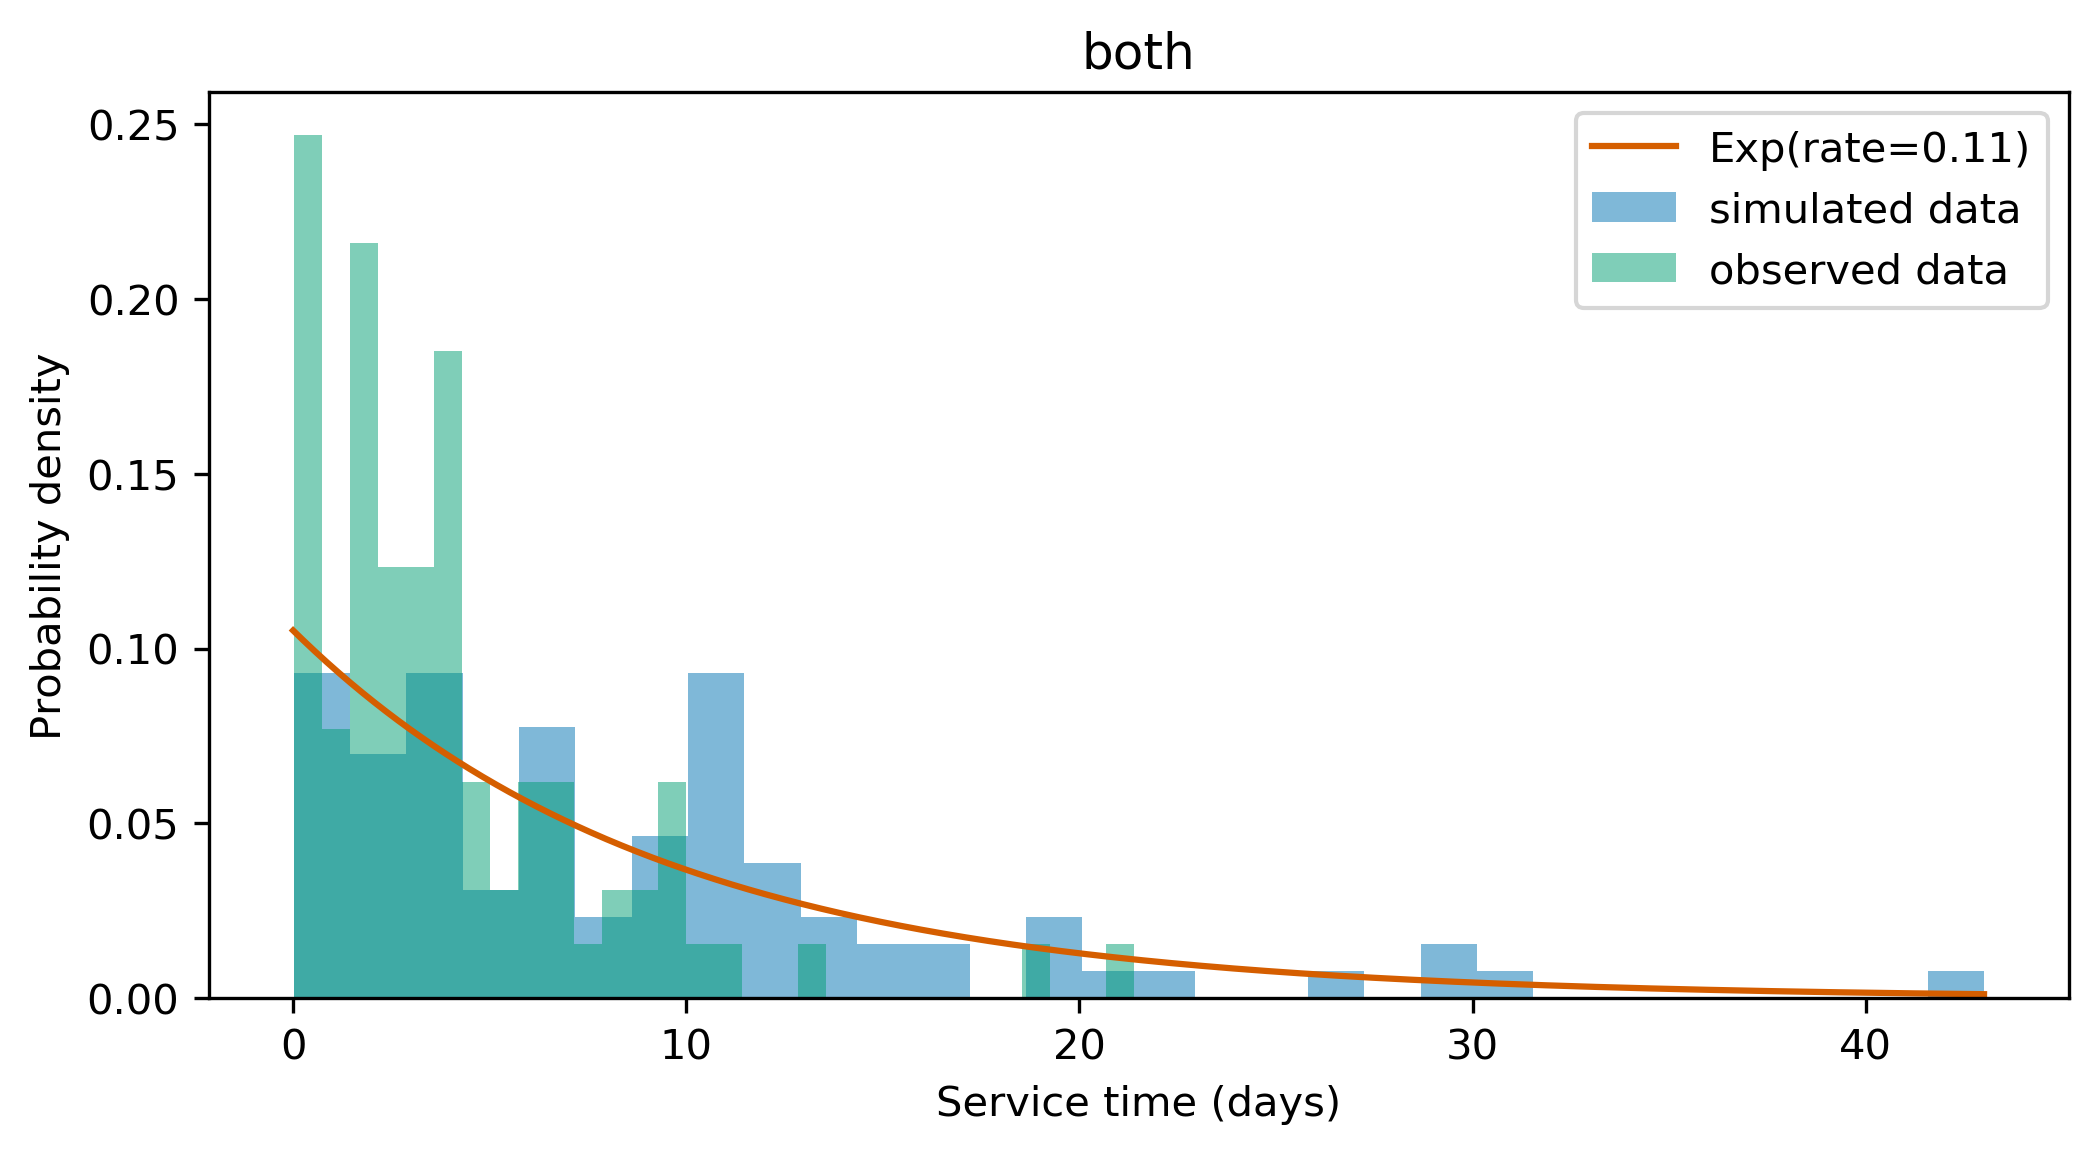

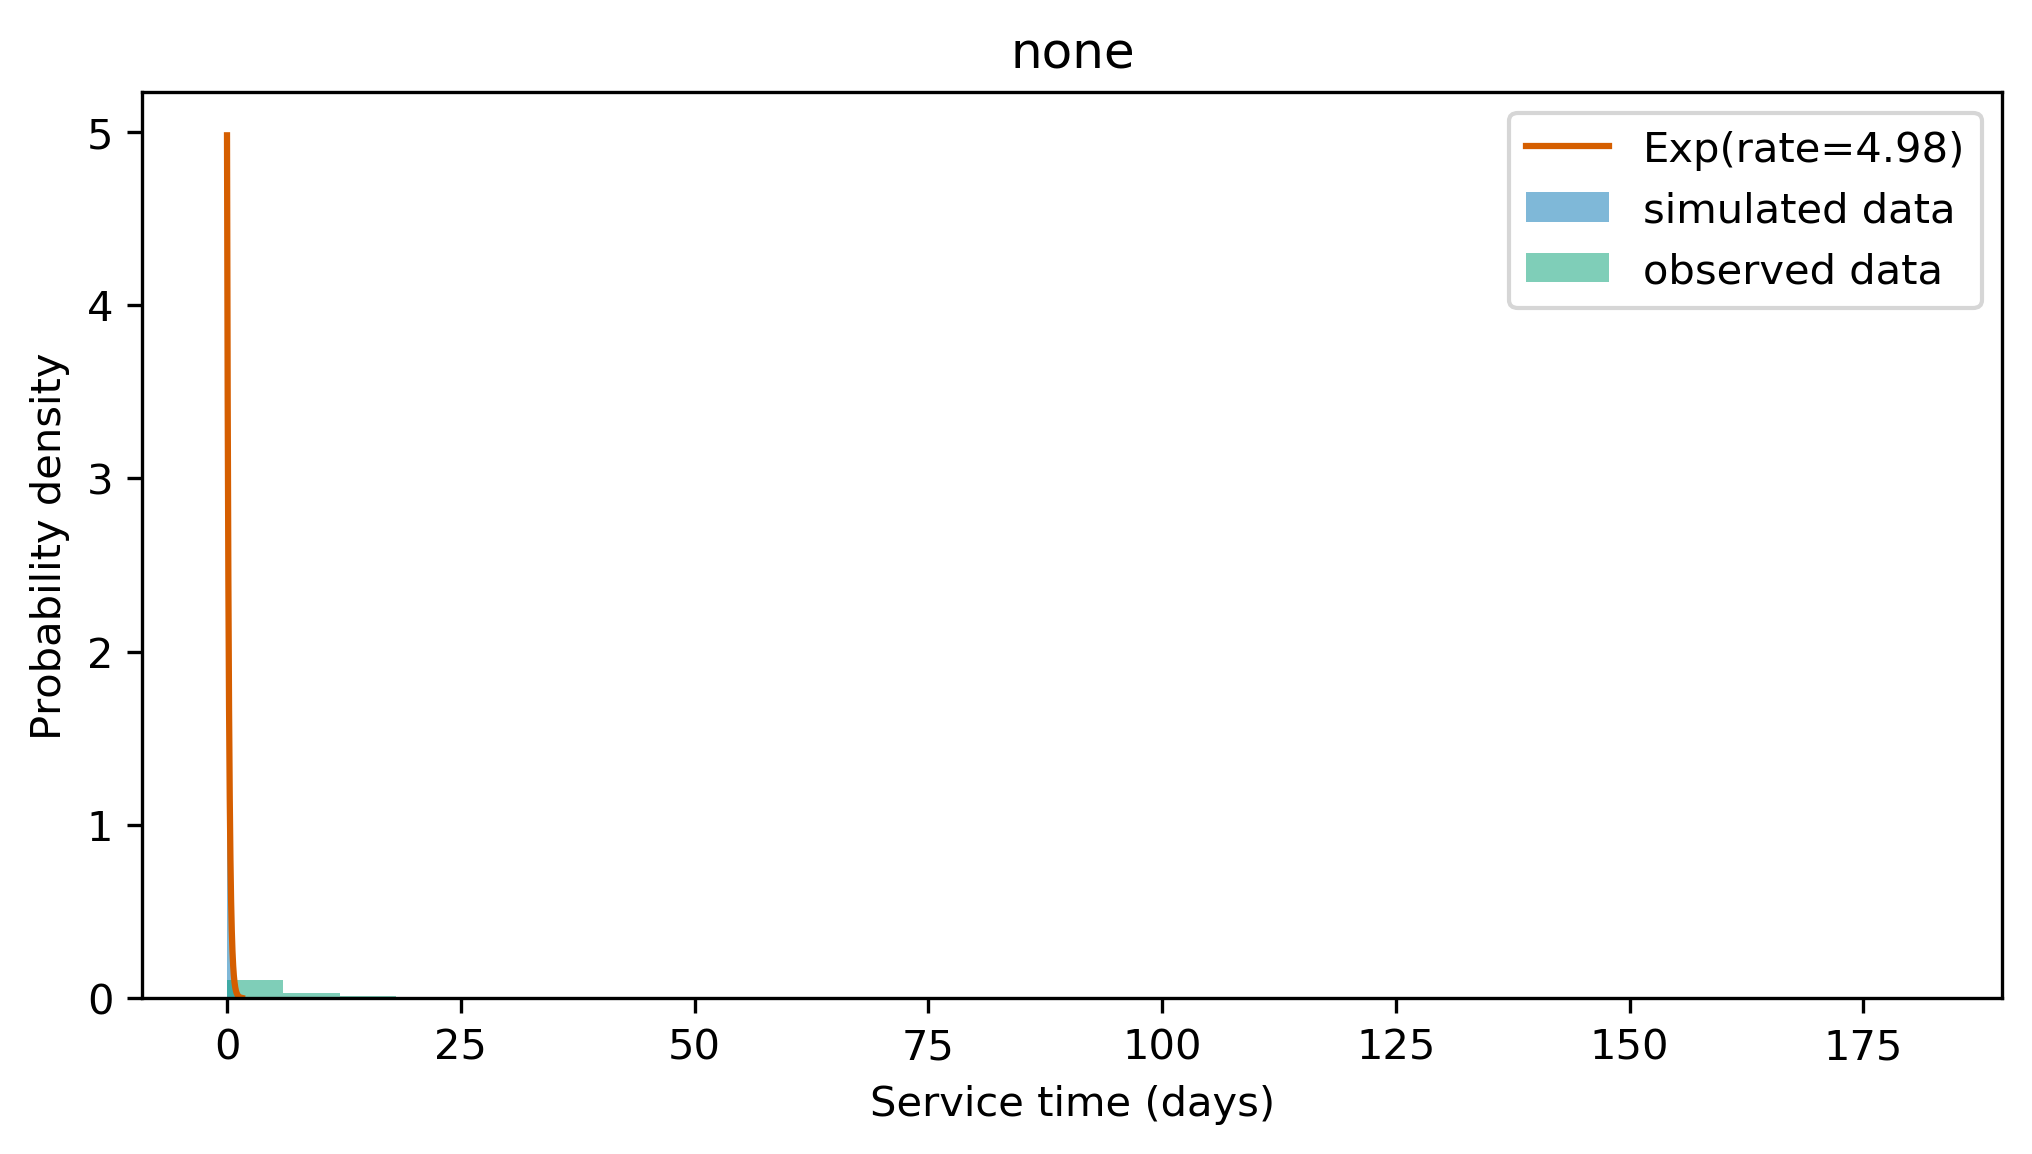

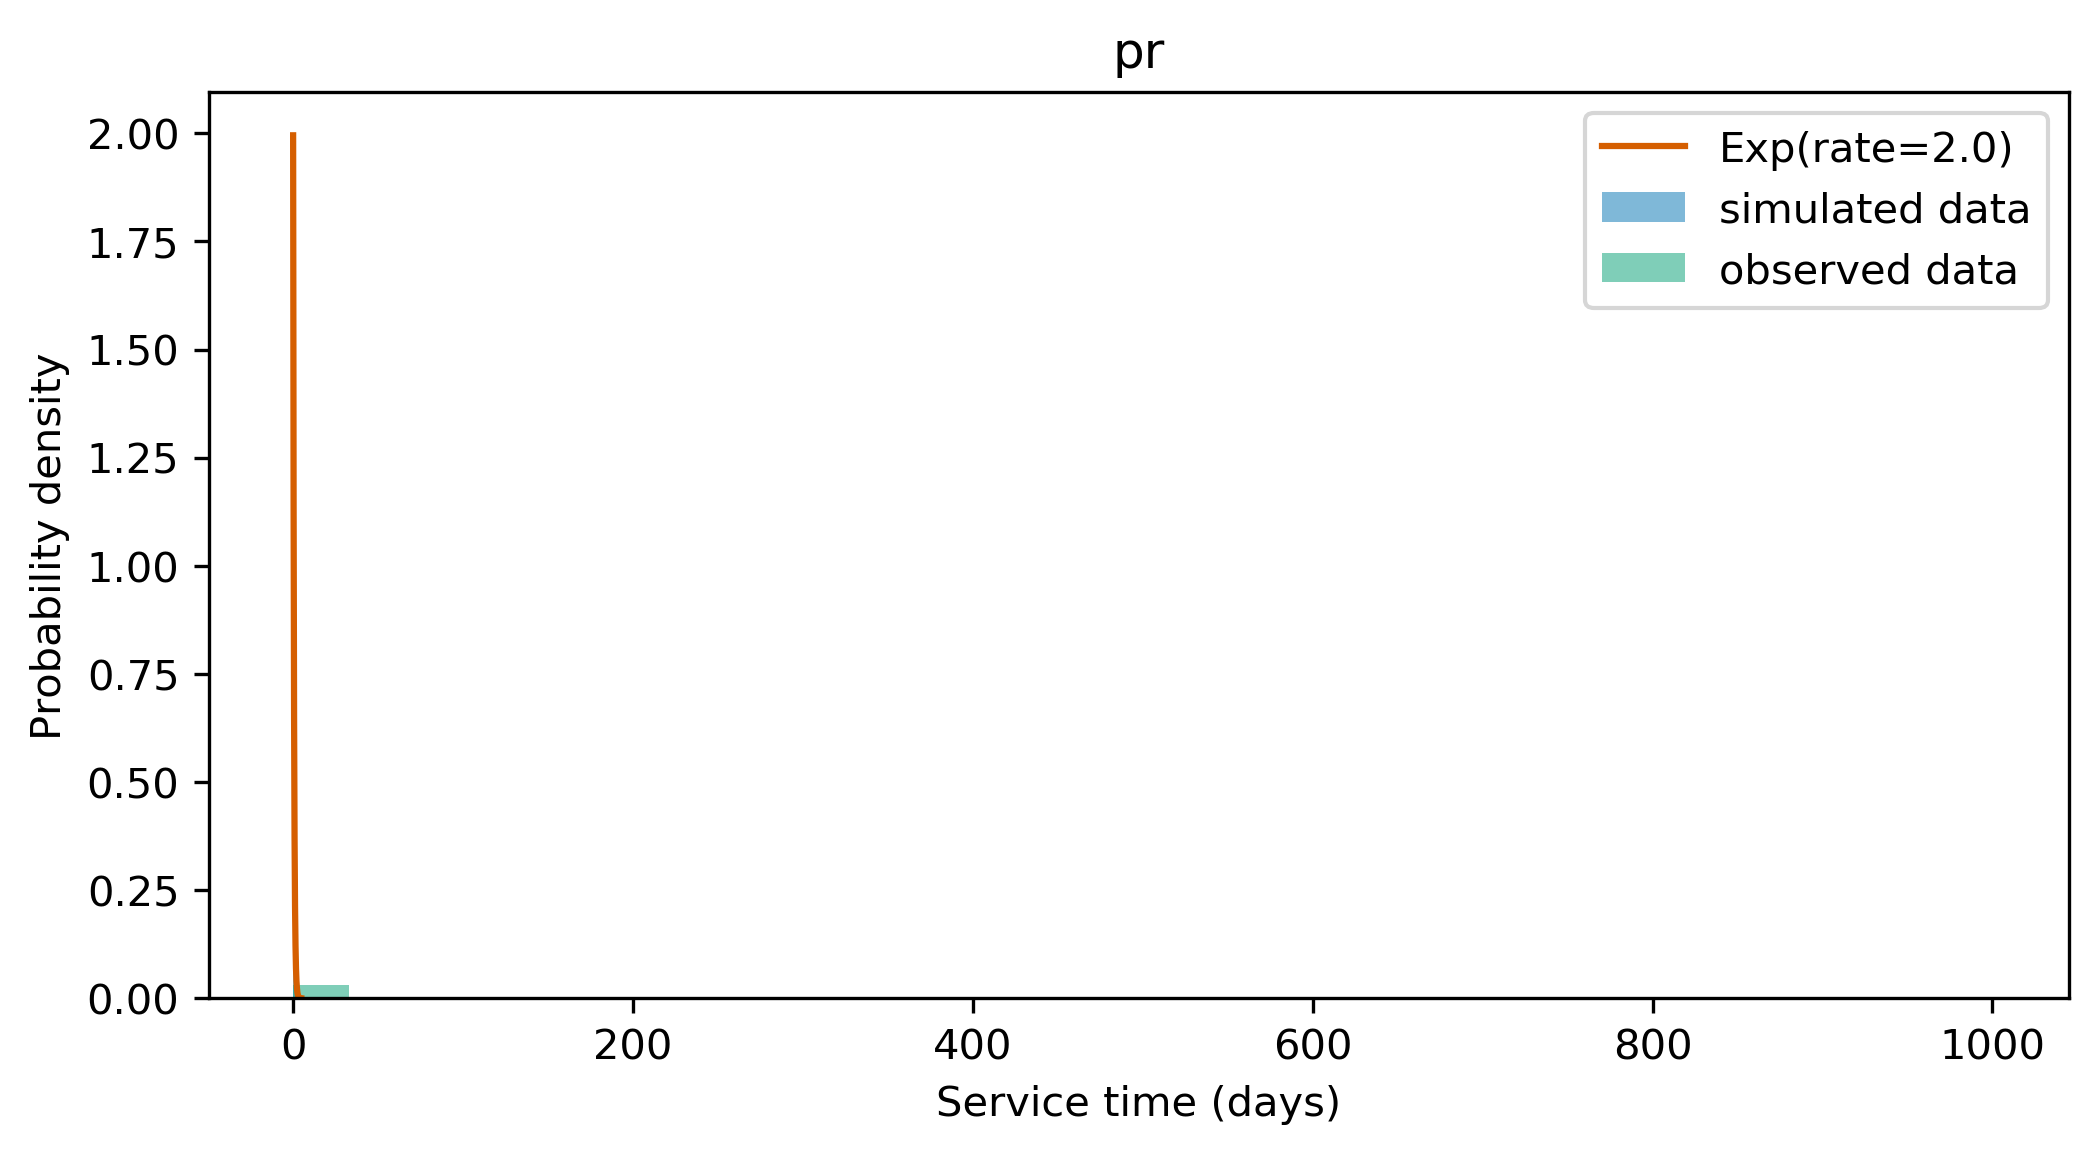

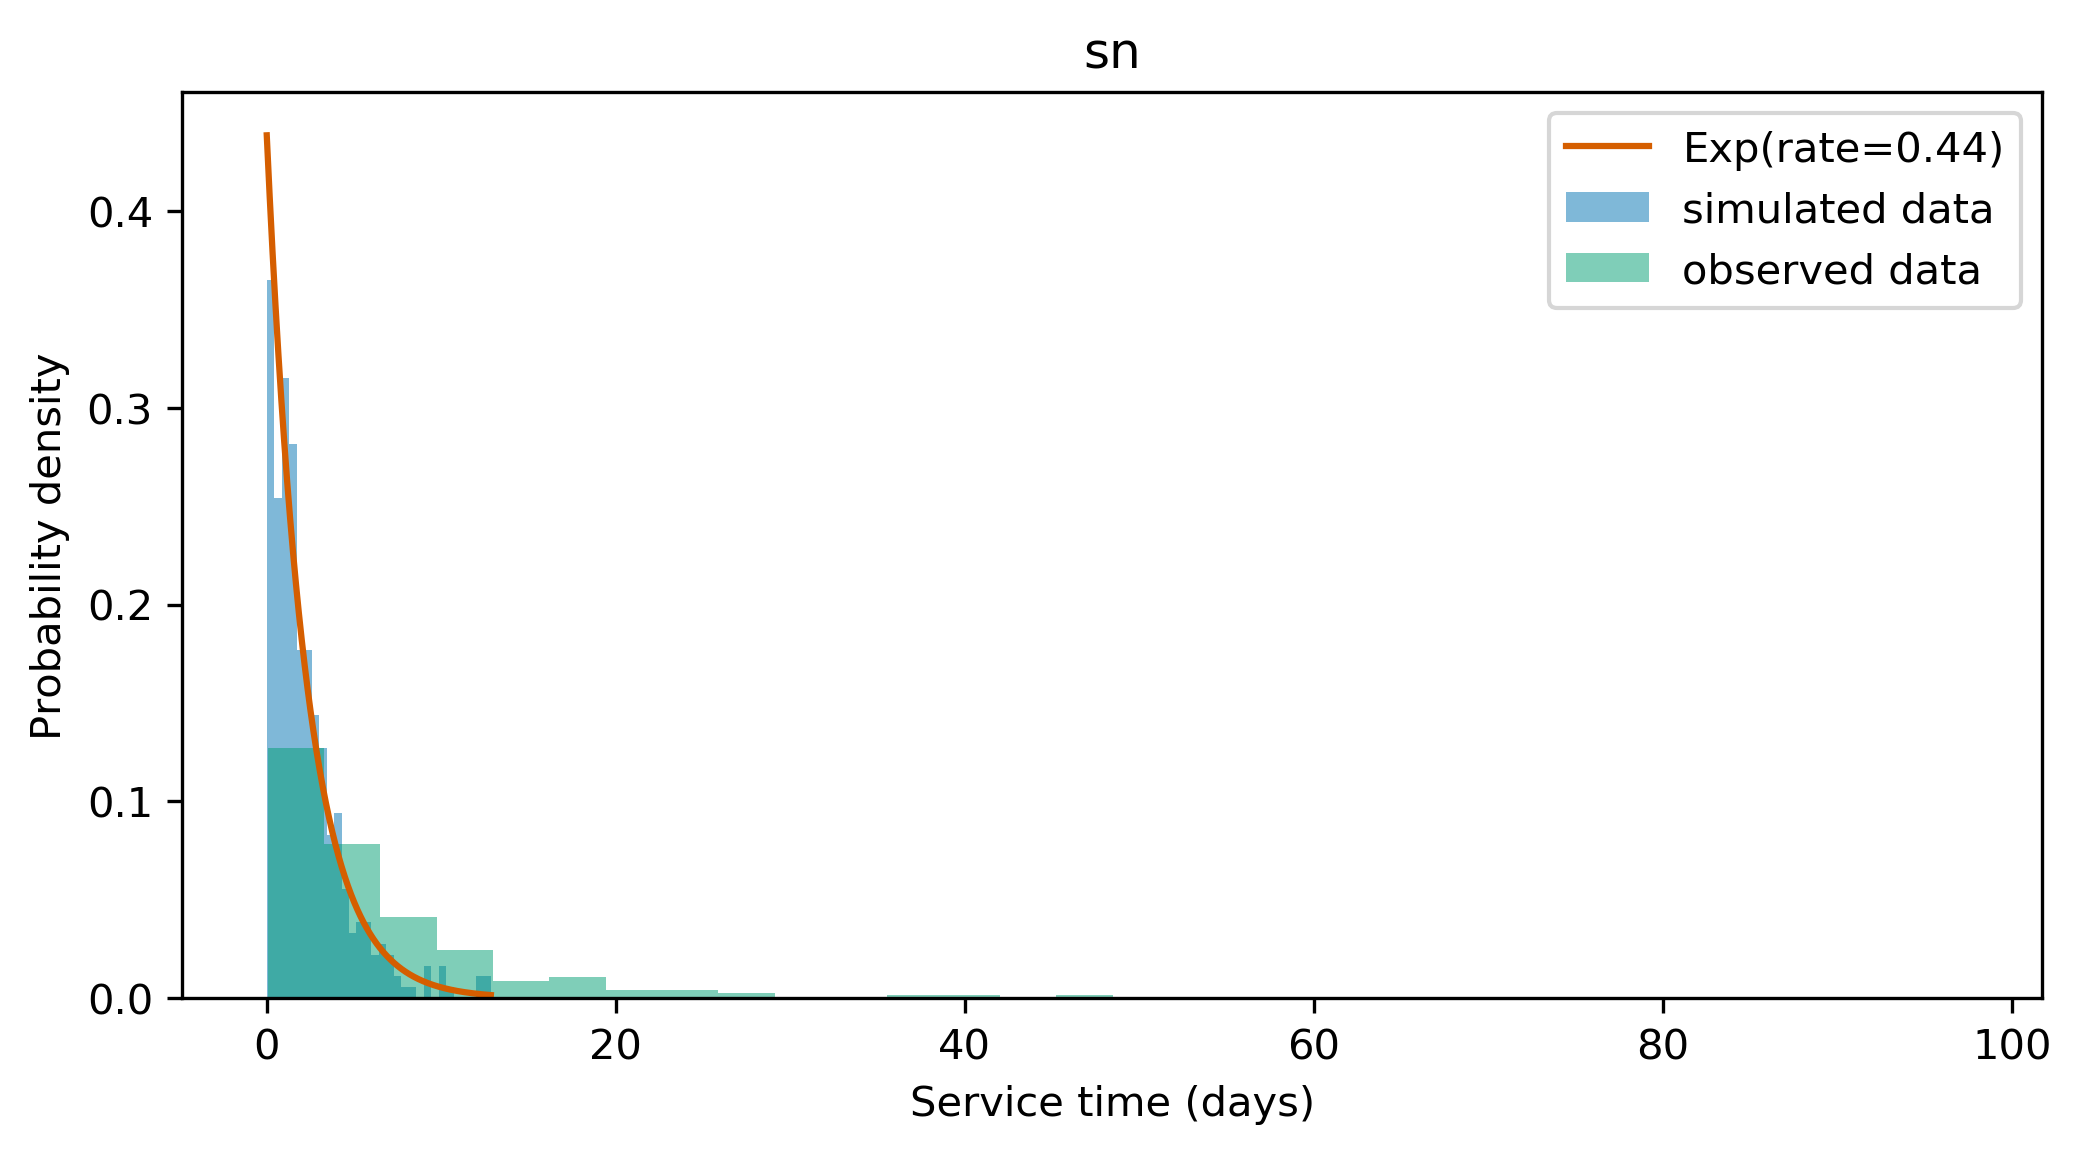

In [6]:
for i, (_, data) in enumerate(results.groupby("customer_class")):

    intervention, params = list(queue_params.items())[i]
    service_rate = params["service"]

    simulated_data = data["service_time"]
    observed_data = copd[copd["intervention"] == intervention]["true_los"]

    fig, ax = plt.subplots(figsize=(8, 4), dpi=300)

    ax.hist(
        simulated_data,
        bins=30,
        density=True,
        alpha=0.5,
        label="simulated data"
    )

    ax.hist(
        observed_data,
        bins=30,
        density=True,
        alpha=0.5,
        label="observed data"
    )

    xs = np.linspace(0, simulated_data.max(), 1000)
    ax.plot(xs, dist.pdf(xs, 0, 1 / service_rate), label=f"Exp(rate={round(service_rate, 2)})")

    ax.set_xlabel("Service time (days)")
    ax.set_ylabel("Probability density")
    ax.set_title(intervention)
    ax.legend()